In [89]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Chargement des datasets MNIST et SVHN

In [109]:
# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation commune pour MNIST et SVHN
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionnement pour SVHN
    transforms.Grayscale(num_output_channels=1),  # Conversion SVHN en niveaux de gris
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement de MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Chargement de SVHN
svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Créer les DataLoader
#train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
#test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)

# DataLoader
mnist_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, drop_last=True)
svhn_loader = DataLoader(svhn_train, batch_size=64, shuffle=True, drop_last=True)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


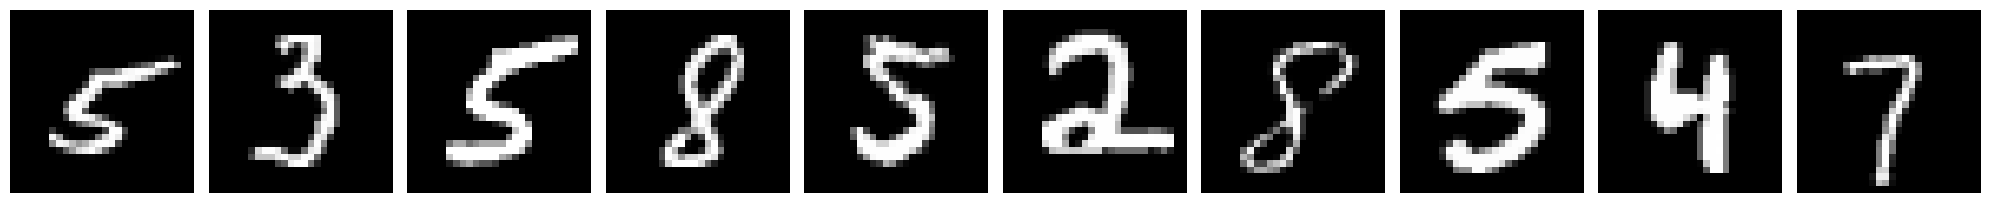

In [110]:
imgs, _ = next(iter(mnist_loader))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

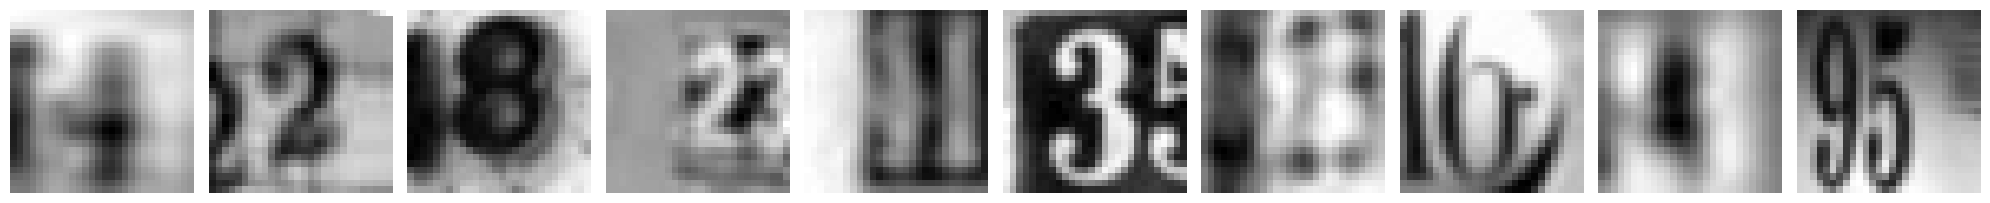

In [111]:
imgs, _ = next(iter(svhn_loader))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = imgs[i].permute(1, 2, 0)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

# Architecture de réseau de neurones

## Test 1 : LeNet

In [93]:
"""
from torch import nn, optim

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 6, 5),  # 1 canal d'entrée pour les images en niveaux de gris, 6 canaux de sortie, kernel de 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pooling avec un kernel de 2 et un stride de 2
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),  # Les dimensions dépendent de la taille de l'image après convolutions et pooling
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)  # 10 classes pour les chiffres de 0 à 9
        )

    def forward(self, x):
        return self.network(x)
"""

"\nfrom torch import nn, optim\n\nclass LeNet(nn.Module):\n    def __init__(self):\n        super(LeNet, self).__init__()\n        self.network = nn.Sequential(\n            nn.Conv2d(1, 6, 5),  # 1 canal d'entrée pour les images en niveaux de gris, 6 canaux de sortie, kernel de 5\n            nn.ReLU(),\n            nn.MaxPool2d(2, 2),  # Pooling avec un kernel de 2 et un stride de 2\n            nn.Conv2d(6, 16, 5),\n            nn.ReLU(),\n            nn.MaxPool2d(2, 2),\n            nn.Flatten(),\n            nn.Linear(16 * 4 * 4, 120),  # Les dimensions dépendent de la taille de l'image après convolutions et pooling\n            nn.ReLU(),\n            nn.Linear(120, 84),\n            nn.ReLU(),\n            nn.Linear(84, 10)  # 10 classes pour les chiffres de 0 à 9\n        )\n\n    def forward(self, x):\n        return self.network(x)\n"

In [94]:
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fonction d'entraînement
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Entraîner le modèle
train_model(model, train_loader, criterion, optimizer)
"""

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = LeNet().to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Fonction d\'entraînement\ndef train_model(model, train_loader, criterion, optimizer, num_epochs=10):\n    for epoch in range(num_epochs):\n        model.train()\n        total_loss = 0\n        for images, labels in train_loader:\n            images, labels = images.to(device), labels.to(device)\n            optimizer.zero_grad()\n            outputs = model(images)\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n            total_loss += loss.item()\n        print(f\'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}\')\n\n# Entraîner le modèle\ntrain_model(model, train_loader, criterion, optimizer)\n'

## Test 2 : GAN

In [98]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            # Ajouter une couche résiduelle
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        return self.main(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [99]:
# Initialisation des modèles
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Définition de la fonction de perte et des optimiseurs
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [100]:
# Fonction pour l'entraînement du GAN
def train_gan(generator, discriminator, mnist_loader, svhn_loader, criterion, g_optimizer, d_optimizer, epochs=10):
    for epoch in range(epochs):
        # Itérer sur les paires de données de MNIST et SVHN
        for (mnist_images, _), (svhn_images, _) in zip(mnist_loader, svhn_loader):
            # Assurer que les images soient sur le bon device
            mnist_images, svhn_images = mnist_images.to(device), svhn_images.to(device)
            batch_size = mnist_images.size(0)  # Taille dynamique du batch

            # Créer les labels pour le batch actuel
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Entraîner le discriminateur avec de vraies images de MNIST
            discriminator.zero_grad()
            outputs_real = discriminator(mnist_images)
            loss_real = criterion(outputs_real, real_labels)

            # Générer de fausses images à partir des images SVHN
            fake_images = generator(svhn_images)
            outputs_fake = discriminator(fake_images.detach())
            loss_fake = criterion(outputs_fake, fake_labels)

            # Calcul et mise à jour de la perte du discriminateur
            d_loss = loss_real + loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Entraîner le générateur pour tromper le discriminateur
            generator.zero_grad()
            outputs_fake_for_training = discriminator(fake_images)
            g_loss = criterion(outputs_fake_for_training, real_labels)
            g_loss.backward()
            g_optimizer.step()

        print(f'Epoch [{epoch + 1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')


# Lancer l'entraînement
train_gan(generator, discriminator, mnist_loader, svhn_loader, criterion, g_optimizer, d_optimizer)

Epoch [1/10] - D Loss: 1.3228, G Loss: 0.7597
Epoch [2/10] - D Loss: 1.3589, G Loss: 0.7531
Epoch [3/10] - D Loss: 1.3654, G Loss: 0.7086
Epoch [4/10] - D Loss: 1.3215, G Loss: 0.7019
Epoch [5/10] - D Loss: 1.3792, G Loss: 0.6997
Epoch [6/10] - D Loss: 1.3317, G Loss: 0.7284
Epoch [7/10] - D Loss: 1.3701, G Loss: 0.7598
Epoch [8/10] - D Loss: 1.3745, G Loss: 0.7179
Epoch [9/10] - D Loss: 1.3933, G Loss: 0.7408
Epoch [10/10] - D Loss: 1.3212, G Loss: 0.7358


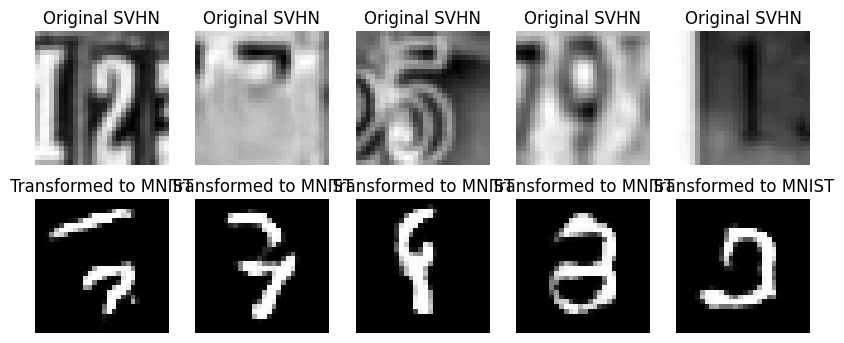

In [103]:
def generate_and_show_images(generator, data_loader, device, num_images=5):
    generator.eval()  # Passer le modèle en mode évaluation
    with torch.no_grad():  # Pas besoin de calculer les gradients
        for images, _ in iter(data_loader):
            images = images.to(device)
            fake_images = generator(images)  # Générer des images qui ressemblent à MNIST
            images = images.cpu()
            fake_images = fake_images.cpu()
            break  # Nous nous arrêtons après avoir traité le premier batch

    # Affichage des images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Affichage des images SVHN originales
        plt.subplot(2, num_images, i + 1)
        # Assurez-vous d'utiliser la permutation correcte pour afficher les images RGB
        plt.imshow(images[i].permute(1, 2, 0), cmap='gray', interpolation='none')
        plt.title("Original SVHN")
        plt.axis('off')

        # Affichage des images transformées
        plt.subplot(2, num_images, num_images + i + 1)
        # Si les images transformées sont censées être en niveaux de gris, utilisez cmap='gray'
        if fake_images.shape[1] == 1:  # Générées en niveaux de gris
            plt.imshow(fake_images[i].squeeze(), cmap='gray', interpolation='none')
        else:  # Générées en couleur
            plt.imshow(fake_images[i].permute(1, 2, 0), interpolation='none')
        plt.title("Transformed to MNIST")
        plt.axis('off')
    plt.show()

# Exemple d'appel de la fonction
generate_and_show_images(generator, svhn_loader, device)


## Test 3 : Cycle GAN

In [125]:
# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation commune pour MNIST et SVHN
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionnement pour SVHN
    transforms.Grayscale(num_output_channels=1),  # Conversion SVHN en niveaux de gris
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement de MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Chargement de SVHN
svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Créer les DataLoader
#train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
#test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)

# DataLoader
mnist_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, drop_last=True)
svhn_loader = DataLoader(svhn_train, batch_size=64, shuffle=True, drop_last=True)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [141]:
## Définition des Blocs Résiduels pour le Générateur
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features)
        )
    def forward(self, x):
        return x + self.block(x)

## Définition du Générateur
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks, output_channels=1):
        super(GeneratorResNet, self).__init__()
        input_channels = input_shape[0]
        out_features = 64
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, out_features, 7, stride=1, padding=0),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        self.model = nn.Sequential(*model)
        self.final = nn.Sequential(
            nn.Conv2d(64, output_channels, kernel_size=7, padding=3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.final(x)
        return x

## Définition du Discriminateur
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [142]:
# Initialisation des modèles
generator_G = Generator(input_channels=1,output_channels=1).to(device)
generator_F = Generator(input_channels=1,output_channels=1).to(device)

discriminator_X = Discriminator(input_channels=1).to(device)
discriminator_Y = Discriminator(input_channels=1).to(device)

# Perte de cycle-consistence (souvent L1)
cycle_loss = torch.nn.L1Loss()

# Optimiseurs pour chaque modèle
optimizer_G = optim.Adam(generator_G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_F = optim.Adam(generator_F.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(discriminator_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(discriminator_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [143]:
def train_cycle_gan(generator_G, generator_F, discriminator_X, discriminator_Y, loader_X, loader_Y, optimizer_G, optimizer_F, optimizer_D_X, optimizer_D_Y, criterion, cycle_loss, epochs):
    for epoch in range(epochs):
        for x, y in zip(loader_X, loader_Y):
            real_X, real_Y = x[0].to(device), y[0].to(device)
            batch_size = real_X.size(0)

            # Réels = 1, Faux = 0
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # -----------------
            #  Entraîner les Générateurs G et F
            # -----------------

            # Met à zéro les gradients des générateurs
            optimizer_G.zero_grad()
            optimizer_F.zero_grad()

            # Génère des images fausses
            fake_Y = generator_G(real_X)
            fake_X = generator_F(real_Y)

            # Calcule la perte pour les générateurs
            g_loss = criterion(discriminator_Y(fake_Y), real_labels)
            f_loss = criterion(discriminator_X(fake_X), real_labels)

            # Calcule la perte de cycle-consistence
            recon_X = generator_F(fake_Y)
            recon_Y = generator_G(fake_X)
            cycle_X_loss = cycle_loss(recon_X, real_X) * 10.0  # Lambda = 10
            cycle_Y_loss = cycle_loss(recon_Y, real_Y) * 10.0

            # Calcule la perte totale pour les générateurs
            total_g_loss = g_loss + f_loss + cycle_X_loss + cycle_Y_loss
            total_g_loss.backward()

            # Met à jour les poids des générateurs
            optimizer_G.step()
            optimizer_F.step()

            # -----------------
            #  Entraîner les Discriminateurs X et Y
            # -----------------

            # Met à zéro les gradients des discriminateurs
            optimizer_D_X.zero_grad()
            optimizer_D_Y.zero_grad()

            # Calcule la perte pour les discriminateurs
            d_X_loss_real = criterion(discriminator_X(real_X), real_labels)
            d_X_loss_fake = criterion(discriminator_X(fake_X.detach()), fake_labels)
            d_Y_loss_real = criterion(discriminator_Y(real_Y), real_labels)
            d_Y_loss_fake = criterion(discriminator_Y(fake_Y.detach()), fake_labels)

            # Calcule la perte totale pour les discriminateurs
            d_X_loss = (d_X_loss_real + d_X_loss_fake) * 0.5
            d_Y_loss = (d_Y_loss_real + d_Y_loss_fake) * 0.5
            d_X_loss.backward()
            d_Y_loss.backward()

            # Met à jour les poids des discriminateurs
            optimizer_D_X.step()
            optimizer_D_Y.step()

        # Affiche les progrès après chaque époque
        print(f'Epoch [{epoch+1}/{epochs}] - G Loss: {total_g_loss.item():.4f}, D_X Loss: {d_X_loss.item():.4f}, D_Y Loss: {d_Y_loss.item():.4f}')

train_cycle_gan(generator_G, generator_F, discriminator_X, discriminator_Y, svhn_loader, mnist_loader, optimizer_G, optimizer_F, optimizer_D_X, optimizer_D_Y, criterion, cycle_loss, epochs = 10)


Epoch [1/10] - G Loss: 3.2962, D_X Loss: 0.7652, D_Y Loss: 0.6169
Epoch [2/10] - G Loss: 2.8875, D_X Loss: 0.7108, D_Y Loss: 0.6787
Epoch [3/10] - G Loss: 2.4042, D_X Loss: 0.6973, D_Y Loss: 0.6894
Epoch [4/10] - G Loss: 2.9272, D_X Loss: 0.6953, D_Y Loss: 0.6542
Epoch [5/10] - G Loss: 2.4851, D_X Loss: 0.7069, D_Y Loss: 0.6635
Epoch [6/10] - G Loss: 2.6125, D_X Loss: 0.7175, D_Y Loss: 0.6955
Epoch [7/10] - G Loss: 2.3701, D_X Loss: 0.6804, D_Y Loss: 0.6986


In [123]:
import matplotlib.pyplot as plt

def display_images(generator_G, generator_F, images_X, images_Y, device):
    """
    Display images transformation results from domain X to Y and Y to X.

    Parameters:
    - generator_G: Generator that converts X to Y.
    - generator_F: Generator that converts Y to X.
    - images_X: Tensor batch of images from domain X.
    - images_Y: Tensor batch of images from domain Y.
    - device: PyTorch device to which tensors should be moved for processing.
    """
    generator_G.eval()
    generator_F.eval()

    with torch.no_grad():
        # Move to device (GPU/CPU)
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)
        
        # Generate fake images
        fake_Y = generator_G(images_X)
        fake_X = generator_F(images_Y)
        
        # Move tensors back to CPU for visualization
        images_X = images_X.cpu()
        images_Y = images_Y.cpu()
        fake_Y = fake_Y.cpu()
        fake_X = fake_X.cpu()

    # Set up the figure
    plt.figure(figsize=(10, 8))
    
    num_images = min(images_X.size(0), 5)  # Display up to 5 pairs of images
    for i in range(num_images):
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(images_X[i].permute(1, 2, 0))
        plt.title("Real X")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(fake_Y[i].permute(1, 2, 0))
        plt.title("Fake Y")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(images_Y[i].permute(1, 2, 0))
        plt.title("Real Y")
        plt.axis("off")

        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(fake_X[i].permute(1, 2, 0))
        plt.title("Fake X")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
images_X, _ = next(iter(svhn_loader))  # Supposons que loader_X est votre DataLoader pour le domaine X
images_Y, _ = next(iter(mnist_loader))  # Supposons que loader_Y est votre DataLoader pour le domaine Y

display_images(generator_G, generator_F, images_X, images_Y, device)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
"""
# Fonction pour évaluer les images transformées avec un modèle de classification MNIST
def evaluate_transformed_images(classifier, transformed_images, labels, criterion, device):
    classifier.eval()
    transformed_loader = DataLoader(TensorDataset(transformed_images, labels), batch_size=64, shuffle=False)
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in transformed_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')
    print(f'Average Loss: {total_loss / len(transformed_loader)}')

"""

"\n# Fonction pour évaluer les images transformées avec un modèle de classification MNIST\ndef evaluate_transformed_images(classifier, transformed_images, labels, criterion, device):\n    classifier.eval()\n    transformed_loader = DataLoader(TensorDataset(transformed_images, labels), batch_size=64, shuffle=False)\n    total_loss = 0\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for images, labels in transformed_loader:\n            images, labels = images.to(device), labels.to(device)\n            outputs = classifier(images)\n            loss = criterion(outputs, labels)\n            total_loss += loss.item()\n            _, predicted = torch.max(outputs.data, 1)\n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n\n    print(f'Accuracy: {100 * correct / total}%')\n    print(f'Average Loss: {total_loss / len(transformed_loader)}')\n\n"